In [1]:
import numpy as np
import apogee.tools.read as apread
from matplotlib import pyplot as plt
import pandas as pd
import csv
from apogee.tools import bitmask
import math
from astropy.io import fits

### About calcR function:
Mirror = A reflected array that is the right side of the CCF, from the peak_loc to the endpoint of the CCF. This array was reflected via ([::-1]) to cover the left side of the CCF.

Sum = np.sum((x[startpoint:peak_loc] - Mirror)**2) which looks like

$ \sum_0^{N}  (x_N - x_{mirror})^2 $ 

So our asymmetrical component holds the form

$ \sigma_a = \sqrt{\frac{1}{2N}  \sum_0^{N}  (x_N - x_{mirror})^2 }$

R = $\frac{H_{CCF}}{\sqrt{2}\sigma_a }$ which is given in the last line as the value to be returned (r).

In [54]:
def calcR(x,pm):
    ccfCenter = max(x)
    primary = np.where(x == ccfCenter)
    peak_loc = primary[0][0]
    #print("primary loc = " + str(peak_loc))
    if peak_loc < pm: 
        pm = peak_loc
    if peak_loc > 401 - pm:
        pm = 401 - peak_loc
    if peak_loc == 0:
        r = 1000
        return r 
        
    endpoint = peak_loc+pm
    startpoint= peak_loc-pm
    Mirror = (x[peak_loc:endpoint])[::-1]
    sigmaA = np.sqrt(1.0*np.sum((x[startpoint:peak_loc] - Mirror)**2) / (2.0*len(Mirror)))
    r = np.max(x) / (np.sqrt(2.0) * sigmaA)
    return r
    

111.58


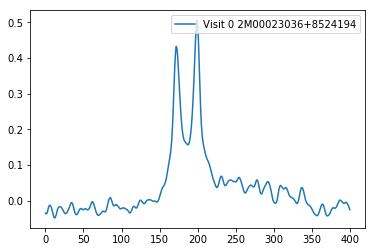

65.261


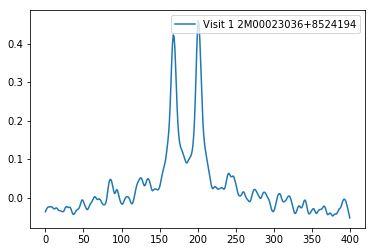

134.918


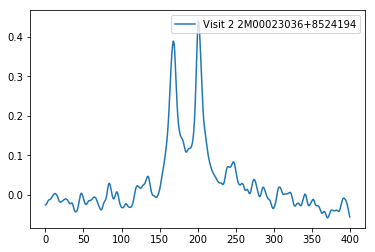

95.8608


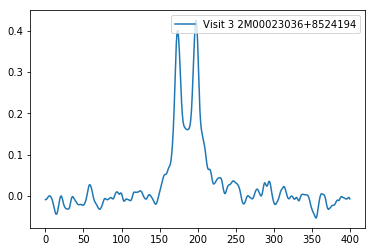

77.4308


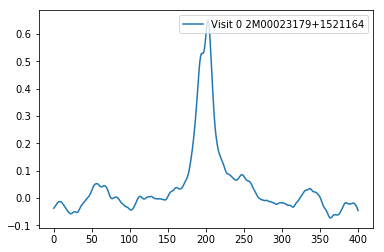

78.9378


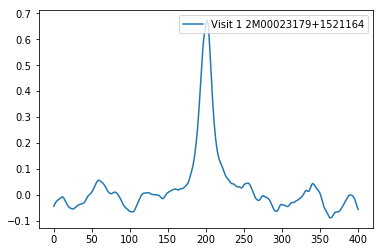

40.5454


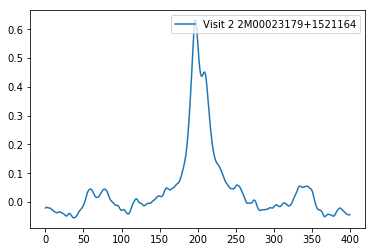

30.7408


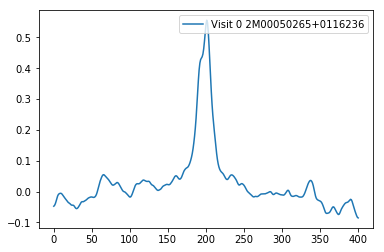

37.8749


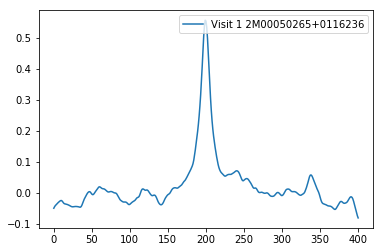

46.3372


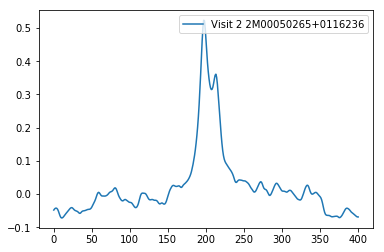

48.2876


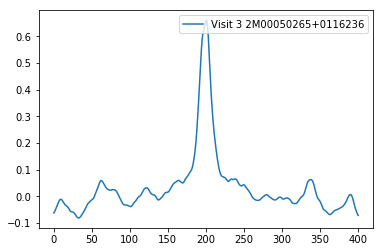

40.2967


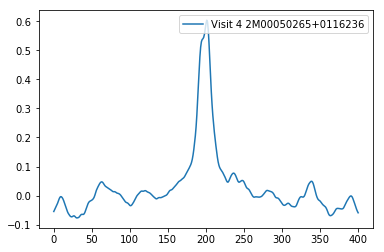

43.4096


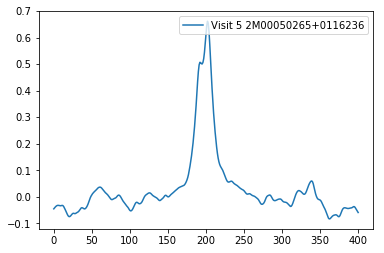

37.2345


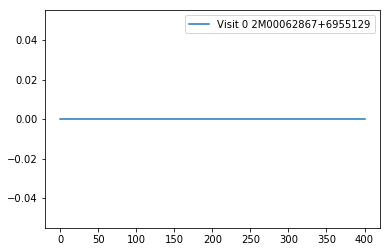

31.3835


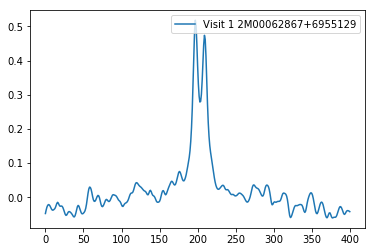

41.1621


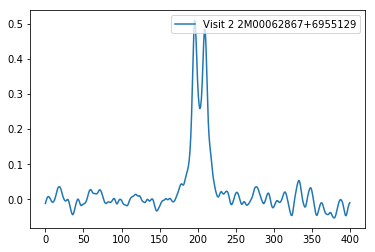

40.4789


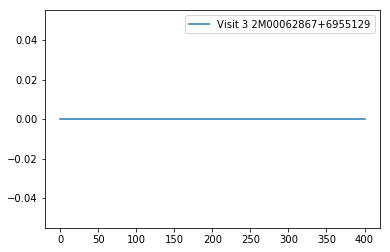

30.4754


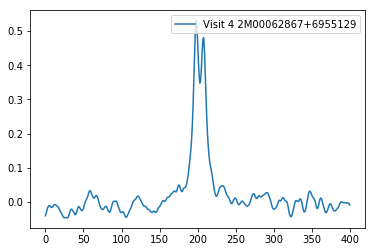

35.9257


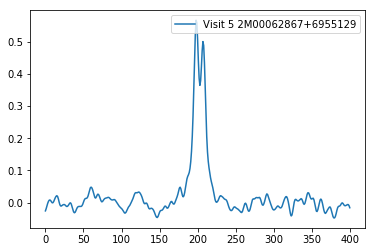

319.646


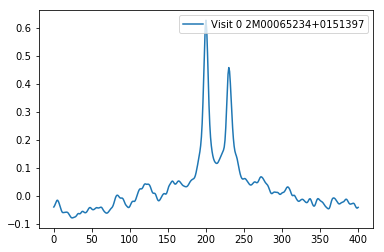

371.561


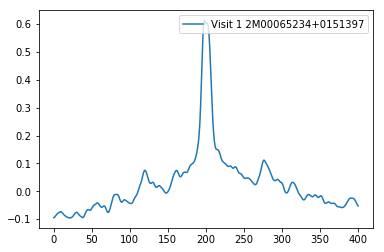

430.665


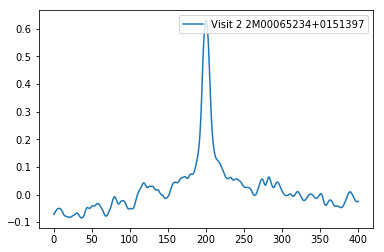

369.6


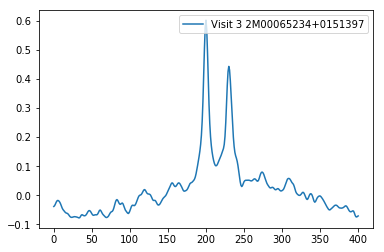

363.804


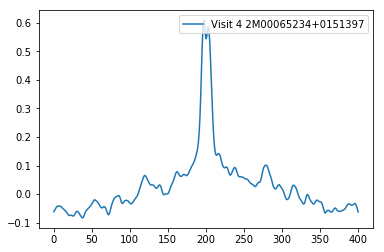

383.469


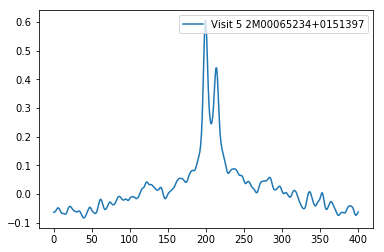

In [108]:
'''
Read in Dr. Covey's IDL Identientified List of SB2s.
Note: The values for SB2s are very low, close to 1! Keep this in mind when accessing the new R thresholds. 
'''
x = pd.read_csv('KC_Binaries.csv',delimiter='\t')
apoID = x['Apogee_ID']
locID = x['Location_ID']

for i in range(5):
    locationID = locID[i]
    apogeeID = apoID[i]
    #print(i,locationID,apogeeID)
    my_file = Path('/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits')
    #if my_file.is_file():
        #path = '/Volumes/coveydata-5/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits'
    try: 
        path = '/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits'
        #print(path) 
    
    except:
        path = '/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStarC-r8-'+str(apogeeID)+'.fits'
        
    data = fits.open(path)
    point = data[9]
    xccf = point.data[0][32]
    CCF = point.data[0][27]
    HDU0 = fits.getheader(path,0)
    nvisits = HDU0['NVISITS']
    for visit in range(0,nvisits):
        #if nvisits != 1:
        ccf = CCF[visit+2]
        snr = HDU0['SNRVIS'+str(visit+1)]
        print(snr)
        plt.plot(ccf,label='Visit '+str(visit)+' '+str(apogeeID))
        plt.legend(loc='upper right')
        plt.show()
        nonzeroes = np.count_nonzero(ccf) # This condition is meant to eliminate visits that are empty
        if nonzeroes >= 1:
            bs_pt = bisector(xccf, ccf)
            x_range = xrange(bs_pt[0])
            #print('--Visit '+str(visit)+'--')
            R151 = calcR(ccf,75)
            R101 = calcR(ccf,50)
            R51 = calcR(ccf,25)
            Ratios = r_ratio(R51,R151,R101)
            r1 = Ratios[0]
            r2 = Ratios[1]

### Notes:
    The calls to calculate R had to be reduced by a value of 1. This is because the reflected array and the other half of the array were reported to have two different sizes therefore could not be boradcasted together. We will either need to justify this or seek the issue that caused the two to be of varying lengths in the first place.
    Find locations where the array start point is less than zero or places where it will exceed 401. 

In [38]:
'''
Read in DR14 and check that paths exist for apStar and apStarC files. 
Calculate the following:
R values, x-range, bisector points, and R ratios.
The purpose of this cell is to test run these calculations and make sure they are working appropriately. 
'''

import os.path
from pathlib import Path

#for i in range(len(locationIDs)):
for i in range(1502,1508):
    locationID = locationIDs[i]
    apogeeID = apogeeIDs[i]
    #print(i,locationID,apogeeID)
    my_file = Path('/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits')
    #if my_file.is_file():
        #path = '/Volumes/coveydata-5/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits'
    try: 
        path = '/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits'
        #print(path) 
    
    except:
        path = '/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStarC-r8-'+str(apogeeID)+'.fits'
        #print(path)
        
    data = fits.open(path)
    point = data[9]
    xccf = point.data[0][32]
    CCF = point.data[0][27]
    HDU0 = fits.getheader(path,0)
    nvisits = HDU0['NVISITS']
    for visit in range(0,nvisits):
        #if nvisits != 1:
        ccf = CCF[visit+2]
        snr = HDU0['SNRVIS'+str(visit+1)]
        print(snr)
        #plt.plot(ccf,label='Visit '+str(visit)+' '+str(apogeeID))
        #plt.legend(loc='upper right')
        #plt.show()
        nonzeroes = np.count_nonzero(ccf) # This condition is meant to eliminate visits that are empty
        if nonzeroes >= 1:
            bs_pt = bisector(xccf, ccf)
            x_range = xrange(bs_pt[0])
            #print('--Visit '+str(visit)+'--')
            R151 = calcR(ccf,75)
            R101 = calcR(ccf,50)
            R51 = calcR(ccf,25)
            Ratios = r_ratio(R51,R151,R101)
            r1 = Ratios[0]
            r2 = Ratios[1]
                    #print(r1,r2)
        

78.0032
18.4913754791
15.7467088069
11.3282201231
74.5626
17.3602923977
14.8778513106
10.7261315063
87.9162
14.6764838517
13.0557666322
9.52056229665
75.6958
14.2125590016
11.859148737
8.54201637102
67.24
14.8579187402
12.3098983889
8.80271087929
51.4531
14.5083483758
12.0186512828
8.55627714969
6.47848
8.49059
2.30719077612
2.79199542558
5.55624112117
3.55216
2.4767307581
2.3965021999
4.86289239603
1.56372
1.7642311252
1.92977595185
2.2444923172
3.44796
2.4607936414
2.65140669
4.06845516458
6.48475
1.59609277025
1.48088430713
1.56617879313
30.2338
14.0480308005
12.1092804317
8.83439943049
57.3104
15.1534793127
12.7082814034
9.06537081882
47.6392
14.900713364
12.5820565053
8.96454594265
94.0095
13.3181492583
11.0044128417
8.0088079535
77.3152
13.932446901
11.5439020712
8.4841996827
136.957
13.2095464347
10.9125533623
7.89266124012
69.5899
13.3744243094
11.3759396841
8.25305011835
26.2306
15.3636344519
14.2530443758
10.773134107
24.8808
14.5038964396
13.4063220484
10.5403560899
31.9398


In [100]:
'''
This R definition is meant to send back an array of:
CCF height, start pt, end pt, length of mirror, sum calculations and sigma a value.
'''
def calcR_add(x,pm):
    ccfCenter = max(x)
    primary = np.where(x == ccfCenter)
    peak_loc = primary[0][0]
    #print("primary loc = " + str(peak_loc))
    if peak_loc < pm: 
        pm = peak_loc
    if peak_loc > 401 - pm:
        pm = 401 - peak_loc
    if peak_loc == 0:
        r = 1000
        return r
        
    endpoint = peak_loc+pm
    startpoint= peak_loc-pm
    Mirror = (x[peak_loc:endpoint])[::-1]
    sums = np.sum((x[startpoint:peak_loc] - Mirror)**2)
    length = len(Mirror)
    sigmaA = np.sqrt(1.0*np.sum((x[startpoint:peak_loc] - Mirror)**2) / (2.0*len(Mirror)))
    #print("a = "+ str(sigmaA))
    height = np.max(x)
    r = np.max(x) / (np.sqrt(2.0) * sigmaA)
    info = np.array([height, startpoint,endpoint,length,sums,sigmaA])
    return info

In [99]:
#Make a sample file of 10 objects (4 binaries and 6 non-binaries)
with open('Sample_For_Rs.csv','w') as outs:
    column = ['Location_ID','Apogee_ID']
    writer = csv.DictWriter(outs,delimiter='\t',fieldnames=column)
    writer.writeheader()
    for j in range(1505,1511):
        locationID = locationIDs[j]
        apogeeID = apogeeIDs[j]
        writer.writerow({'Location_ID':locationID,'Apogee_ID':apogeeID})
        
    j=0
    for j in range(0,4):
        locatID = locID[j]
        apogeID = apoID[j]
        writer.writerow({'Location_ID':locatID,'Apogee_ID':apogeID})


In [105]:
#read in csv and construct table of source, visit, max(x), sigma_a, start pt, end pt, mirror, sums
'''
This cell is for generating a sample file for Dr.Covey of 10 sources: binary (last 4) and non-binary (top 6).
'''
y = pd.read_csv('Sample_For_Rs.csv',delimiter='\t')
twomass = y["Apogee_ID"]
field = y['Location_ID']

with open('SampleTable_Stats.csv','w') as file:
    column = ['Location_ID','Apogee_ID','Visit','SNR','stpt75','endpt75','Mirror75','Sums75','sigma_a75','R151',
              'CCF_Height', 'stpt50','endpt50','Mirror50','Sums50','sigma_a50','R101', 'stpt25','endpt25',
              'Mirror25', 'Sums25','sigma_a25','R51']
    write = csv.DictWriter(file,delimiter='\t', fieldnames=column)
    write.writeheader()
    i = 0
    for i in range(len(y)):
        locationID = field[i]
        apogeeID = twomass[i]
        my_file = Path('/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits')
        try: 
            path = '/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits'

        except:
            path = '/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStarC-r8-'+str(apogeeID)+'.fits'

        data = fits.open(path)
        point = data[9]
        xccf = point.data[0][32]
        CCF = point.data[0][27]
        HDU0 = fits.getheader(path,0)
        nvisits = HDU0['NVISITS']
        for visit in range(0,nvisits):
            ccf = CCF[visit+2]
            snr = HDU0['SNRVIS'+str(visit+1)]
            nonzeroes = np.count_nonzero(ccf) # This condition is meant to eliminate visits that are empty
            if nonzeroes >= 1:
                R151 = calcR(ccf,75)
                R101 = calcR(ccf,50)
                R51 = calcR(ccf,25)
                stats75 = calcR_add(ccf, 75)    
                height = stats75[0]
                stpt75 = stats75[1]
                edpt75 = stats75[2]
                lm75 = stats75[3]
                s75 = stats75[4]
                sa75 = stats75[5]
                stats50 = calcR_add(ccf, 50)
                stpt50 = stats75[1]
                edpt50 = stats50[2]
                lm50 = stats75[3]
                s50 = stats75[4]
                sa50 = stats75[5]
                stats25 = calcR_add(ccf, 25)
                stpt25 = stats75[1]
                edpt25 = stats50[2]
                lm25 = stats75[3]
                s25 = stats75[4]
                sa25 = stats75[5]
                write.writerow({'Location_ID':locationID,'Apogee_ID':apogeeID,'Visit':visit,'SNR':snr,
                                'stpt75': stpt75,'endpt75': edpt75,'Mirror75':lm75,
                                'Sums75': s75, 'CCF_Height':height,'sigma_a75':sa75,'R151':round(R151,3),
                                'stpt50':stpt50,'endpt50':edpt50,'Mirror50':lm50,
                                'Sums50':s50,'sigma_a50':sa50,'R101':round(R101,3),
                                'stpt25':stpt25,'endpt25':edpt25,'Mirror25':lm25,
                                'Sums25':s25,'sigma_a25':sa25,
                                'R51':round(R51,3)})


In [3]:
def bisector(xccf,yccf):
    height = max(yccf) - min(yccf)
    slices = height/4.0
    bounds = np.arange(min(yccf),height,slices)
    if len(bounds) != 0:
        z1 = (bounds[0] + bounds[1])/2.0
        z2 = (bounds[1] + bounds[2])/2.0
        z3 = (bounds[2] + bounds[3])/2.0
        z4 = (bounds[3] + bounds[4])/2.0
        y_bisector = np.array([z1,z2,z3,z4])

        x_bisector = []
        x0 = []
        x1 = []
        x2 = []
        x3 = []
        for i in range(len(yccf)):
            if yccf[i] <= bounds[4] and yccf[i] > bounds[3]:
                x0.append(xccf[i])
        x_0 = (np.mean(x0))
        x_bisector.append(x_0)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[3] and yccf[i] >= bounds[2]:
                x1.append(xccf[i])
        x_1=(np.mean(x1))
        x_bisector.append(x_1)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[2] and yccf[i] >= bounds[1]:
                x2.append(xccf[i])
        x_2=(np.mean(x2))
        x_bisector.append(x_2)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[1] and yccf[i] >= bounds[0]:
                x3.append(xccf[i])
        x_3=(np.mean(x3))
        x_bisector.append(x_3)

        bisector_pts = np.vstack([x_bisector,y_bisector])
        #print(bisector_pts)
        return(bisector_pts)
    #else:
        #x_bisector = 0.0
        #y_bisector = 0.0
        #error = np.vstack([x_bisector,y_bisector])
        return(error)

In [4]:
def xrange(x_bisector):
    #print(x_bisector)
    xr = max(x_bisector) - min(x_bisector)
    return xr

In [6]:
'''
This function was being used for finding the width of a CCF by locating the maxima, find the midpoint (y-direction),
and take the difference in lag space (x-direction) of the indicides that told where the sides of the CCF was.
The later steps still need to be implimented. 
'''
def FindMaxima(xccf,CCF,peak_loc):
    thresh_down = 1
    if peak_loc > 7:
        peak_low = peak_loc-2
    else:
        peak_low = peak_loc+1
    while thresh_down > 0:
        if peak_low > 2 and (CCF[peak_low-1] - CCF[peak_low] < 0) and CCF[peak_low-1] > 0:
            peak_low = peak_loc-1
        else:
            thresh_down = 0
    thresh_up = 1
    if peak_loc < 394:
        peak_high = peak_loc+2
    else:
        peak_high = peak_loc-1
    while thresh_up > 0:
        if peak_high < 399 and (CCF[peak_high+1] - CCF[peak_high] < 0) and (CCF[peak_high+1] > 0):
            peak_high = peak_high+1
        else:
            thresh_up = 0
    n_lag = np.arange(0,402,1)
    walk = np.zeroes(n_lag)
    
'''    if peak_low < 0:
        peak_low = 0
    if else peak_high > n_lag-1:
        peak_high = n_lag-1
        
    walk[peak_low:peak_high] = 1''';
    
    
    

In [5]:
#Calculate the R-ratios for the likely_binary function
def r_ratio(r51,r151,r101):
        if r51!=0 and r151!=0 and r101!=0:
            r1_ratio = r151/r101
            r2_ratio = r101/r51
            R1_ratio = math.log10(r1_ratio)
            R2_ratio = math.log10(r2_ratio)
            ratios = [round(R1_ratio,3),round(R2_ratio,3)]
        else:
            ratios = ["N/A","N/A"]
        return ratios

In [6]:
#def idSB2s(CCF,xr,r51,r151,r101): # cuts to identify SB2s
    #min_r51 = min(r51)
    #min_r101 = min(r101)
    #min_r151 = min(r151)
    #peak_401 = max(CCF) - min(CCF)
    #max_xr = max(xr)
def idSB2s(R1_ratio, R2_ratio,r51,r151,r101,xr): # cuts to identify SB2s from Kevin's IDL Routine
    min_r51 = r51
    min_r101 = r101
    min_r151 = r151
    r1_ratio = R1_ratio
    r2_ratio = R2_ratio
    max_xr = xr
    
    likely_sb2s = np.where((math.log10(r1_ratio) > 0.06 and (math.log10(r1_ratio) < 0.13 and 
                            math.log10(min_r101) < 0.83)) or (math.log10(r2_ratio) > 0.05 and 
                            math.log10(r2_ratio) < 0.02 and math.log10(min_r51) < 0.83) and
                            math.log10(min_r51) > 0.25 and math.log10(min_r101) > 0.22 and
                            math.log10(peak_401) > -0.5 and math.log10(max_xr) < 2.3 and 
                            math.log10(max_xr) > 0.7
                          )
    return likely_sb2s

In [7]:
from astropy.io import fits

In [8]:
allStarDR14 = apread.allStar(rmcommissioning=False,main=False,ak=True,akvers='targ',adddist=False)
locationIDs = allStarDR14['LOCATION_ID']
apogeeIDs = allStarDR14['APOGEE_ID']
apogeeIDs = [s.decode('utf-8') for s in apogeeIDs]

In [ ]:
# Read in the file and find how many are SB2s. 
'''
When opening the file, be sure to impliment a test that will extract all R = 1000 and output them into
a file for visual inspection later. What could be the cause of so many having a peak located at 0?
Feed this file to the idSB2 function!
'''
stats = pd.read_csv('DR14_Stats_Catalog.csv',delimiter='/t')
FieldID = stats['Location_ID']
TwoMassID = stats['Apogee_ID']
Star_Visit = stats['Visit']
logR1 = stats['R151/R101']
logR2 = stats['R101/R51']
R51s = stats['R51']
R101s = stats['R101']
R151s = stats['R151']
xr_value = stats['x_range']

with open('DR14_SB2_Catalog.csv','w') as files:
    column = ['Location_ID','Apogee_ID']
    writer = csv.DictWriter(files,delimiter='\t',fieldnames=column)
    writer.writeheader()
    i = 0
    r1 = []
    r2 = []
    r51 = []
    r101 = []
    r151 = []
    xranges = []
    SB2 = []
    for i in range(len(FieldID)):
        if Visit[i] == Visit[i]:
            r1.append(logR1[i])
            r2.append(logR2[i])
            r51.append(R51s[i])
            r101.append(R101s[i])
            r151.append(R151s[i])
            xranges.append(xr_value[i])
        likely_binary = likely_SB2s(r1, r2,r51,r151,r101,xranges)
        index_locID = FieldID[likely_binary]
        index_apoID = TwoMassID[likely_binary]
        SB2.append([index_locID,index_apoID])
        writer.writerow({'Location_ID': SB2[0] ,'Apogee_ID':SB2[1]})

In [ ]:
#Check that these are true SB2s visually! Open the file of SB2s and plot the CCFs
Sb2_data = pd.read_csv('DR14_SB2_Catalog.csv',delimiter='/t')
locIds = Sb2_data['Location_ID']
apoIds = Sb2_data['Apogee_ID']

for j in range(len(apoIds)):
    location_ID = locIds[j]
    apogee_ID = apoIds[j]
    header = apread.apStar(location_ID,apogee_ID,ext=0,header=True)
    data = apread.apStar(location_ID,apogee_ID,ext=9,header=False)
    nvisits=header[1]['NVISITS']
    
    for visit in range(nvisits):
        if nvisits != 1:
            CCF = data['CCF'][0][2+visit]
            plt.title(str(location_ID)+str(apogee_ID))
            plt.plot(CCF+visit,label='Visit '+ str(visit))
            plt.xlabel('CCF Lag',fontsize=10)
            plt.ylabel('$\widehat{CCF}$ Units', fontsize=10)
            plt.legend(loc='upper right')
            #plt.savefig('PSB2Fig_'+str(location_ID)+'-'+str(apogee_ID)+'-'+str(visit)+'.png',dpi=900)
            #plt.xlim(100,300)
            #plt.show()
            #plt.close('all')
                    
        else:
            CCF = data['CCF'][0]
    #except FileNotFoundError:
            #pass
    

## Issue: 
Current array for R values is being over written. It will find the min but then suddenly skip to an empty array. It must be the main programs for loop!

Additionally, Something is wrong with the bisector x-value calculations. They are in decimal values instead of whole integers. The code below is less precise than the one above

In [ ]:
# Main Routine
xccf = np.arange(0,402,1)
with open('SB2_Catalog.csv','w') as output:
    names = ['Location_ID','Apogee_ID','R_401','R_151','R_101','R_51','Max_XR','Visit']
    writer = csv.DictWriter(output,delimiter='\t',fieldnames=names)
    writer.writeheader()
    #try:
    for i in range(20):
            location_ID = locationIDs[i]
            apogee_ID = apogeeIDs[i]
            header = apread.apStar(location_ID,apogee_ID,ext=0,header=True)
            data = apread.apStar(location_ID,apogee_ID,ext=9,header=False)
            nvisits=header[1]['NVISITS']
            #R151 = array_builder(location_ID,apogee_ID,nvisits)
            XR = []
            for visit in range(nvisits):
                if nvisits != 1:
                    CCF = data['CCF'][0][2+visit]
                    bs_pts = bisector(xccf,CCF)
                    x_range = xrange(bs_pts[0])
                    print(x_range)
                    R401 = calcR401(CCF)
                    R151 = calcR151(CCF)
                    R101 = calcR101(CCF)
                    R51 = calcR51(CCF)
                    XR.append(x_range)
                    writer.writerow({'Location_ID':location_ID,'Apogee_ID':apogee_ID,'R_401':round(R401,3)
                                 ,'R_151':round(R151,3),'R_101':round(R101,3),'R_51':round(R51,3),
                                     'Max_XR':round(max(XR),3), 'Visit':visit})
                                     #'Max_XR':round(x_range,3), 'Visit':visit})
                    #plt.plot(CCF,label=str(apogee_ID))
                    #plt.legend(loc='upper right')
                    #plt.xlim(100,300)
                    #plt.show()
                    
                else:
                    CCF = data['CCF'][0]
                #writer.writerow({'Location_ID':location_ID,'Apogee_ID':apogee_ID,'R_401':round(R401,3)
                                 #,'R_151':round(R151,3),'R_101':round(R101,3),'R_51':round(R51,3),
                                    # 'Max_XR':round(max(XR),3), 'Visit':visit})
               
    #except FileNotFoundError:
            #pass